## 单流体嵌入网络的PBFs聚合物

In [23]:
from time import time
from datetime import datetime
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import random, genfromtxt
from IPython.display import display
from matplotlib import rc
from matplotlib.pyplot import figure
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
import matplotlib.ticker as mticker

In [24]:
current_directory = os.getcwd()
print(current_directory)

/home/redfu/work/Constitutive_Equation/MFNN/singlefluid


In [25]:
# 设置数据类型
DTYPE = torch.float32

# 设置随机种子
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

df = {}
optionM=2 # 0:训练储存模量；1：训练损耗模量
# 读取数据
# url_lf = 'Oscillatory/Data_LF_AS_Gp.xlsx'
url_hf = 'Data_HF.xlsx'

# df_LF = pd.read_excel(url_lf, sheet_name=None)
# data_LF = [[k, v] for k, v in df_LF.items()]  # k is the sheet name, v is the pandas df

df_HF = pd.read_excel(url_hf, sheet_name=None)
data_HF = [[k, v] for k, v in df_HF.items()]  # k is the sheet name, v is the pandas df

sample = 1
data_HF[sample][1] = data_HF[sample][1].dropna()

df_hf = data_HF[sample][1]  # entire data

data_HF[sample][1] = data_HF[sample][1][data_HF[sample][1].DP != 161]

# 划分验证集
data_valid=df_hf[df_hf.DP == 162.]

# 转换为 PyTorch 张量
#x1_d_LF = torch.tensor(data_LF[sample][1]['Strain'].values, dtype=torch.float32).view(-1, 1)
#x2_d_LF = torch.tensor(data_LF[sample][1]['Temperature'].values, dtype=torch.float32).view(-1, 1)
#x3_d_LF = torch.tensor(data_LF[sample][1]['AngFreq'].values, dtype=torch.float32).view(-1, 1)
#y1_d_LF = torch.tensor(data_LF[sample][1]['StorageM'].values, dtype=torch.float32).view(-1, 1)

x1_d_HF = torch.tensor(data_HF[sample][1]['DP'].values, dtype=torch.float32).view(-1, 1)
x2_d_HF = torch.tensor(data_HF[sample][1]['Mn'].values, dtype=torch.float32).view(-1, 1)
x3_d_HF = torch.tensor(data_HF[sample][1]['PDI'].values, dtype=torch.float32).view(-1, 1)
x4_d_HF = torch.tensor(data_HF[sample][1]['AngFreq'].values, dtype=torch.float32).view(-1, 1)
y1_d_HF = torch.tensor(data_HF[sample][1]['LossFactor'].values, dtype=torch.float32).view(-1, 1)

# 对 HF 数据进行对数变换
x4_d_HF = torch.log10(x4_d_HF) # 频率对数化
#y1_d_HF = torch.log10(y1_d_HF) # 损耗角对数化

# 计算边界

x1min, x1max = torch.min(x1_d_HF), torch.max(x1_d_HF)
x2min, x2max = torch.min(x2_d_HF), torch.max(x2_d_HF)
x3min, x3max = torch.min(x3_d_HF), torch.max(x3_d_HF)
x4min, x4max = torch.min(x4_d_HF), torch.max(x4_d_HF)
y1min, y1max = torch.min(y1_d_HF), torch.max(y1_d_HF)
# 索引3,4,5为对数化
lb = torch.tensor([x1min, x2min, x3min, x4min,y1min], dtype=torch.float32).numpy()
ub = torch.tensor([x1max, x2max, x3max, x4max,y1max], dtype=torch.float32).numpy()
# 归一化函数
def norm(vectors, lb, ub):
    normalized_vectors = (vectors - lb) / (ub - lb)
    return normalized_vectors

x1_d_HF = norm(x1_d_HF, lb[0], ub[0])
x2_d_HF = norm(x2_d_HF, lb[1], ub[1])
x3_d_HF = norm(x3_d_HF, lb[2], ub[2])
x4_d_HF = norm(x4_d_HF, lb[3], ub[3])
y1_d_HF = norm(y1_d_HF, lb[4], ub[4])
# 合并数据
X_data_HF = torch.cat([x1_d_HF, x2_d_HF, x3_d_HF,x4_d_HF], dim=1)
y_data_HF= torch.cat([y1_d_HF], dim=1) # 默认训练储存模量
#X_data_LF = torch.cat([x1_d_LF, x2_d_LF, x3_d_LF], dim=1)
#y_data_LF = torch.cat([y1_d_LF], dim=1)

Xy_data_HF = torch.cat([X_data_HF,y_data_HF], dim=1)
#Xy_data_LF = torch.cat([x1_d_LF, x2_d_LF, x3_d_LF, y1_d_LF], dim=1)

Shuffle = False # 是否打乱训练
if Shuffle:
    Xy_data_HF = Xy_data_HF[torch.randperm(Xy_data_HF.size(0))]
    #Xy_data_LF = Xy_data_LF[torch.randperm(Xy_data_LF.size(0))]
    X_data_HF = Xy_data_HF[:, 0:4]
    y_data_HF = Xy_data_HF[:, 4:5]
    #X_data_LF = Xy_data_LF[:, 0:3]
    #y_data_LF = Xy_data_LF[:, 3:4]

# 定义模型
in_dim, out_dim = 4, 1

In [26]:
x1_d_valid = torch.tensor(data_valid['DP'].values, dtype=torch.float32).view(-1, 1)
x2_d_valid = torch.tensor(data_valid['Mn'].values, dtype=torch.float32).view(-1, 1)
x3_d_valid = torch.tensor(data_valid['PDI'].values, dtype=torch.float32).view(-1, 1)
x4_d_valid = torch.tensor(data_valid['AngFreq'].values, dtype=torch.float32).view(-1, 1)
y1_d_valid = torch.tensor(data_valid['LossFactor'].values, dtype=torch.float32).view(-1, 1)

# 对 HF 数据进行对数变换
x4_d_valid = torch.log10(x4_d_valid) # 频率对数化
#y1_d_valid = torch.log10(y1_d_valid) # 损耗因子对数化

x1_d_valid = norm(x1_d_valid, lb[0], ub[0])
x2_d_valid = norm(x2_d_valid, lb[1], ub[1])
x3_d_valid = norm(x3_d_valid, lb[2], ub[2])
x4_d_valid = norm(x4_d_valid, lb[3], ub[3])
y1_d_valid = norm(y1_d_valid, lb[4], ub[4])

# 合并数据
X_data_valid = torch.cat([x1_d_valid, x2_d_valid, x3_d_valid,x4_d_valid], dim=1)
y_data_valid= torch.cat([y1_d_valid], dim=1)

In [27]:
# 神经网络的类
class PINN_NeuralNet(nn.Module):
    """ Set basic architecture of the PINN model."""

    def __init__(self,
                 input_dim=0,
                 output_dim=1,  # 默认输出维度为1
                 num_hidden_layers=4, 
                 num_neurons_per_layer=20,
                 activation='tanh',
                 kernel_initializer='glorot_normal',
                 **kwargs):
        super(PINN_NeuralNet, self).__init__()

        self.num_hidden_layers = num_hidden_layers
        self.output_dim = output_dim
        
        # 添加输入层
        self.input_layer = nn.Linear(input_dim, num_neurons_per_layer)
        
        # 添加其他隐藏层
        self.hidden_layers = nn.ModuleList()
        for _ in range(num_hidden_layers):
            self.hidden_layers.append(nn.Linear(num_neurons_per_layer, num_neurons_per_layer))
        
        # 添加输出层
        self.out = nn.Linear(num_neurons_per_layer, output_dim)
        # 设置激活函数
        if activation == 'tanh':
            self.activation = torch.tanh
        elif activation == 'relu':
            self.activation = F.relu6
        elif activation == 'sigmoid':
            self.activation = torch.sigmoid
        elif activation == 'linear':
            self.activation = None
        else:
            raise ValueError("Unsupported activation function")
        
        # 初始化权重
        if kernel_initializer == 'glorot_normal':
            nn.init.xavier_normal_(self.input_layer.weight)
            for hidden_layer in self.hidden_layers:
                nn.init.xavier_normal_(hidden_layer.weight)
            nn.init.xavier_normal_(self.out.weight)
        elif kernel_initializer == 'glorot_uniform':
            nn.init.xavier_uniform_(self.input_layer.weight)
            for hidden_layer in self.hidden_layers:
                nn.init.xavier_uniform_(hidden_layer.weight)
            nn.init.xavier_uniform_(self.out.weight)
        else:
            raise ValueError("Unsupported kernel initializer")

    def forward(self, X):

        # 进入输入层
        Z = self.input_layer(X)
        
        # 通过隐藏层
        for hidden_layer in self.hidden_layers:
            Z = hidden_layer(Z)
            if self.activation is not None:
                Z = self.activation(Z)
        # 通过输出层输出
        Z = self.out(Z)
        
        return Z

In [28]:
# 神经网络处理器类
class PINNSolver():

    # 类属性定义
    def __init__(self, model_HF_nl, model_HF_l):
        # self.model_LF = model_LF # 低保真模型
        self.model_HF_nl = model_HF_nl # 高保真非线性模型
        self.model_HF_l = model_HF_l # 高保真线性模型
        # Initialize history of losses and global iteration counter
        self.hist =  [[], []] # loss历史列表,0:train loss ;1:valid loss
        self.iter = 0 # 迭代次数
        self.last_n_losses = [] # 前损失列表

    # 更新损失列表   
    def update_last_n_losses(self, loss):
        self.last_n_losses.append(loss)
        if len(self.last_n_losses) > 20:
            self.last_n_losses.pop(0)

    # 计算最大相对误差        
    def ES(self):
        if len(self.last_n_losses) < 20:
            return 100  # a large number

        current_loss = self.last_n_losses[-1]
        max_relative_error = 100.*max([abs(current_loss - loss) / current_loss for loss in self.last_n_losses[:-1]])
        return max_relative_error
    
    # 计算loss，模型核心
    def loss_fn(self, X_data_HF, y_data_HF,X_data_valid,y_data_valid):
        y_pred_valid_nl = self.model_HF_nl(X_data_valid)

        y_pred_valid_l = self.model_HF_l(X_data_valid)

        y_pred_valid = y_pred_valid_nl + y_pred_valid_l       
        #y_pred_LF = self.model_LF(X_data_LF)

       # y_pred_LF_HF = self.model_LF(X_data_HF)
   
        y_pred_HF_nl = self.model_HF_nl(X_data_HF)

        y_pred_HF_l = self.model_HF_l(X_data_HF)

        y_pred_HF = y_pred_HF_nl + y_pred_HF_l

        Loss_L2 = 1e-5 * sum(torch.sum(w_**2) for w_ in self.model_HF_nl.parameters())
        Loss_L2 += 1e-5 * sum(torch.sum(w_**2) for w_ in self.model_HF_l.parameters())
        #Loss_data_LF = torch.mean((y_data_LF - y_pred_LF)**2)

        Loss_data_HF = torch.mean((y_data_HF - y_pred_HF)**2)+Loss_L2
        Loss_data_valid=torch.mean((y_pred_valid-y_data_valid)**2)+Loss_L2
                
        return Loss_data_HF,Loss_data_valid
    # 训练核心函数，包括loss计算梯度计算和反向传播
    def solve_with_PyTorch_optimizer(self, optimizer,data,scheduler,N=1001):
        """This method performs a gradient descent type optimization."""        
        for i in range(N):
            # 梯度清0
            optimizer.zero_grad()
            # 计算loss          
            loss,loss_valid = self.loss_fn(data[0], data[1],data[2],data[3])
            # 反向传播计算梯度
            loss.backward()
            # 根据loss调度学习率
            scheduler.step(loss)
            # 反向传播更新权重和偏置
            optimizer.step()

            # 记录loss并计算相对误差
            self.current_loss = loss.item()
            self.valid_loss=loss_valid.item()
           
            self.max_relative_error = self.ES()
            self.callback(self.max_relative_error,N)  # Pass max_relative_error to the callback function
            self.update_last_n_losses(self.current_loss)

            # 早停机制
            if self.max_relative_error < 2e-3: # in %
                print('Early stopping... \nIt {:05,d}: Loss = {:10.4e}, Max. rel. error = {} %'.format(self.iter,
                                                             self.current_loss,
                                                            np.round(self.max_relative_error, 3)))
                break

    # 打印loss    
    def callback(self, xr=None,N=1001):
        if self.iter % 1000 == 0:
            print('It {:05,d}: Loss = {:10.4e}, Max. rel. error = {} %'.format(self.iter,
                                                             self.current_loss,
                                                            np.round(self.max_relative_error, 2)))
        self.hist[0].append(self.current_loss)
        self.hist[1].append(self.valid_loss)
        self.iter+=1
    
    def plot_loss_history(self, ax=None):
        if not ax:
            fig = plt.figure(figsize=(7, 5))
            ax = fig.add_subplot(111)

        # 绘制训练集损失曲线
        ax.semilogy(range(len(self.hist[0])), self.hist[0], 'b-', label='Training Loss')
        
        # 绘制验证集损失曲线
        ax.semilogy(range(len(self.hist[1])), self.hist[1], 'g-', label='Validation Loss')

        ax.set_xlabel('$n_{epoch}$')
        ax.set_ylabel('$loss$')
        ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f'{int(x):,}'))
        ax.legend()  # 添加图例
        return ax

In [29]:
# 定义模型
#model_LF = PINN_NeuralNet(input_dim=in_dim,
#                          output_dim=out_dim,
#                          num_hidden_layers=4,
#                          num_neurons_per_layer=64,
#                          activation='tanh'
#                          )
model_HF_nl = PINN_NeuralNet(input_dim=in_dim,
                             output_dim=out_dim,
                             num_hidden_layers=4,
                             num_neurons_per_layer=64,
                             activation='relu')
model_HF_l = PINN_NeuralNet(input_dim=in_dim,
                            output_dim=out_dim,
                            num_hidden_layers=1,
                            num_neurons_per_layer=10,
                            activation='linear')

# 初始化 PINNSolver
solver = PINNSolver(model_HF_nl, model_HF_l)

In [30]:
# 定义学习率调度器
lr = 1e-3
optimizer = optim.Adam(list(model_HF_nl.parameters()) + list(model_HF_l.parameters()), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=10, verbose=True)
# 定义训练模式
mode = 'PyTorch_optimizer'
N = int(1000) + 1  # 训练迭代次数

try:
    runtime
except NameError:
    runtime = 0.

if mode == 'PyTorch_optimizer':
    try:
        t0 = time()
        solver.solve_with_PyTorch_optimizer(optimizer, [X_data_HF,y_data_HF,X_data_valid,y_data_valid],scheduler,N=N)
        runtime += (time() - t0) / 60.
        print('\nRuntime: {:.3f} minutes'.format(runtime))
    except KeyboardInterrupt:
        runtime += (time() - t0) / 60.
        print('\nRuntime: {:.3f} minutes'.format(runtime))

It 0,000: Loss = 1.8476e-01, Max. rel. error = 100 %
Epoch   279: reducing learning rate of group 0 to 9.0000e-04.
Epoch   356: reducing learning rate of group 0 to 8.1000e-04.
Epoch   418: reducing learning rate of group 0 to 7.2900e-04.
Epoch   517: reducing learning rate of group 0 to 6.5610e-04.
Epoch   604: reducing learning rate of group 0 to 5.9049e-04.
Epoch   700: reducing learning rate of group 0 to 5.3144e-04.
Epoch   811: reducing learning rate of group 0 to 4.7830e-04.
Epoch   926: reducing learning rate of group 0 to 4.3047e-04.
It 1,000: Loss = 1.8057e-03, Max. rel. error = 0.25 %

Runtime: 0.396 minutes


<Axes: xlabel='$n_{epoch}$', ylabel='$loss$'>

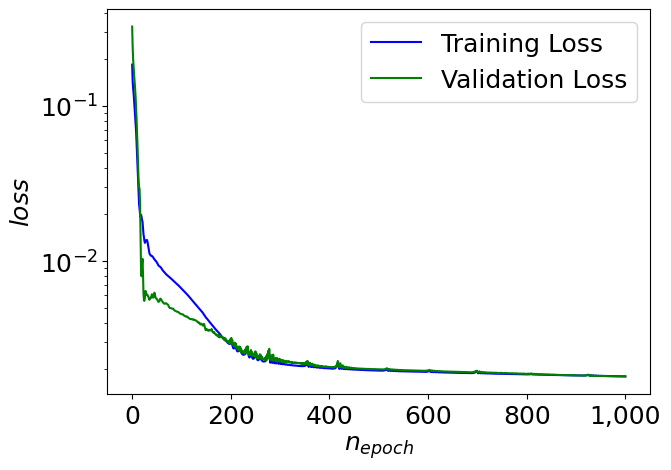

In [31]:
solver.plot_loss_history()

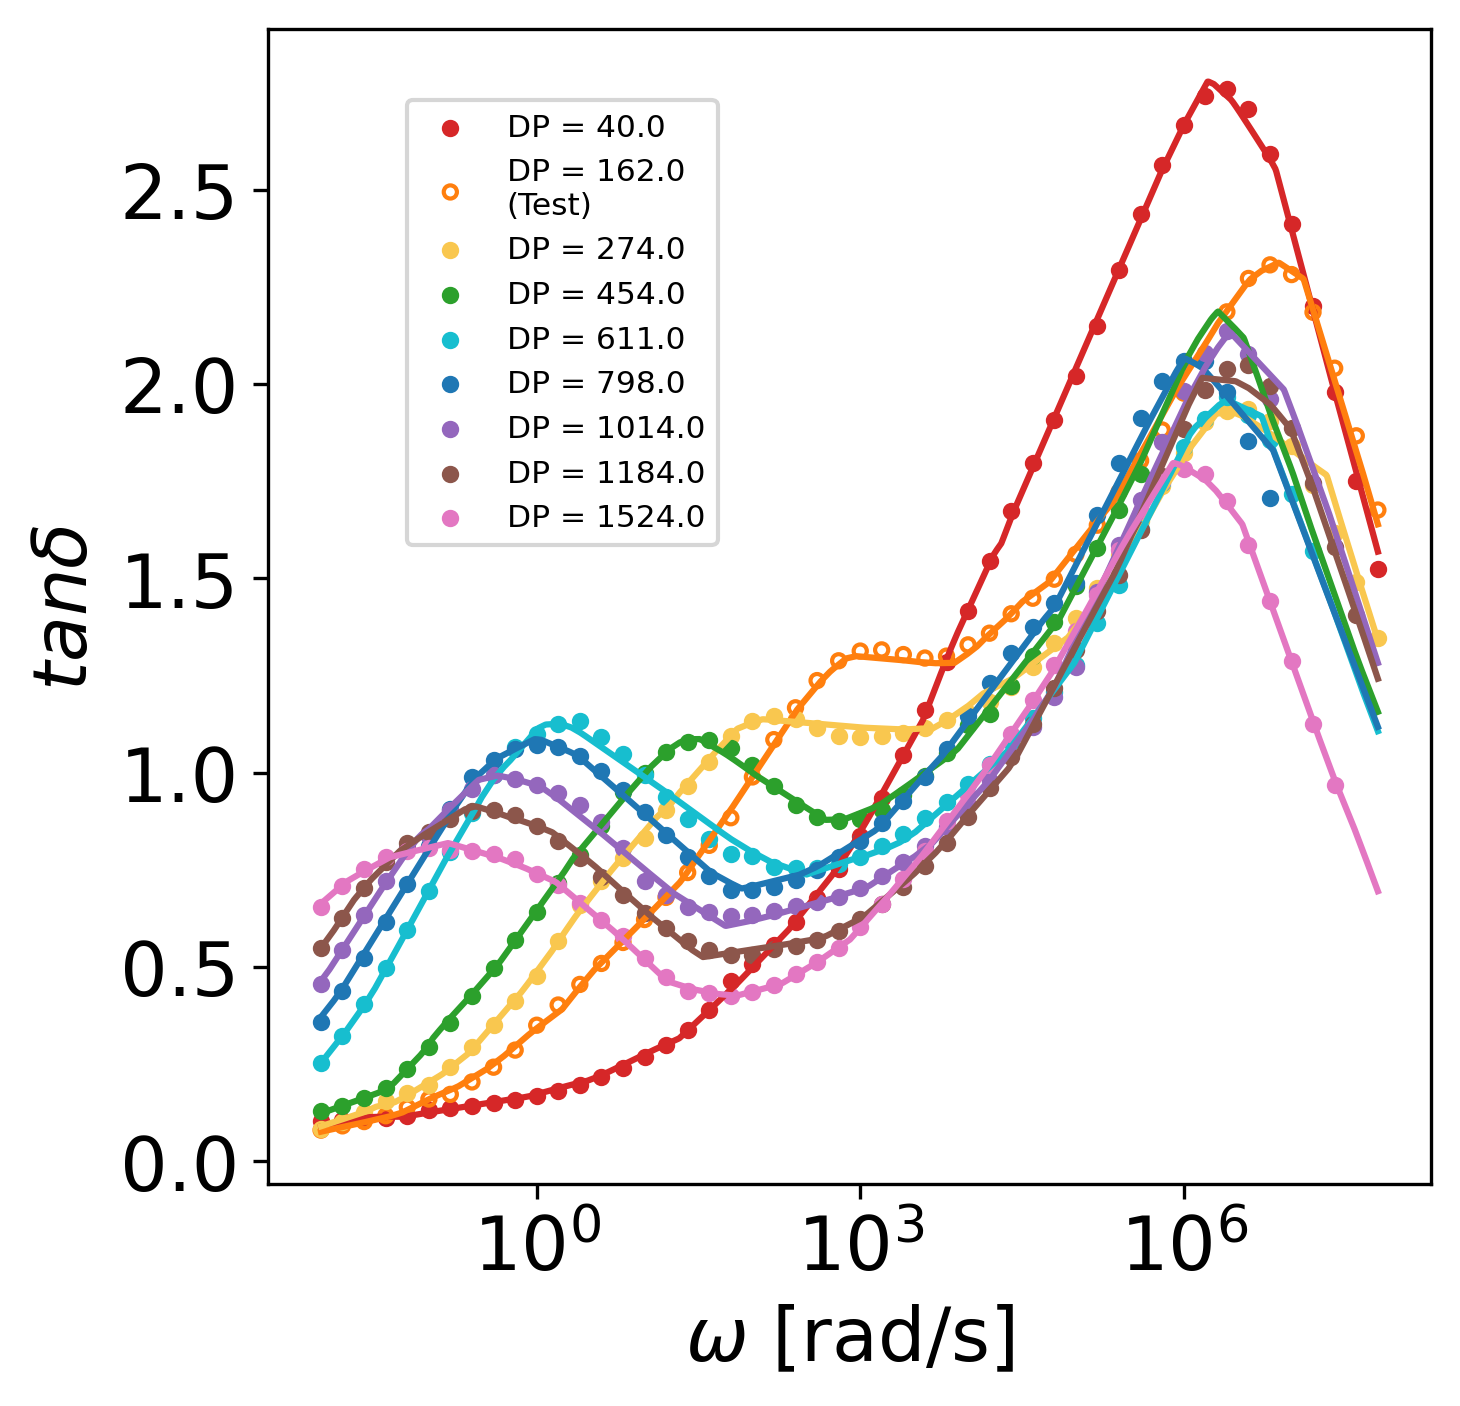

In [32]:
plt.rc('font', size=18)
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('legend', fontsize=18)
plt.rc('figure', titlesize=18)
colors = ['tab:red', 'tab:orange', '#f9c74f', 'tab:green', 'tab:cyan', 'tab:blue', 'tab:purple', 'tab:brown', 'tab:pink']

fig, ax = plt.subplots(figsize=(5, 5), dpi=300)
def denorm(normalized_vectors, lb, ub):
    original_vectors = normalized_vectors * (ub - lb) + lb
    return original_vectors

N_exp = 1000
# 构建1000个绘图的频率点，3为对数化后的上下限,所以这里的w_plot的点都是对数化后的
w_plot = np.linspace(lb[3], ub[3], N_exp).reshape(-1, 1)
# 这里是要画不同DP的曲线
DP_range = [40., 162., 274., 454., 611.,798.,1014.,1184.,1524.]

for i in range(len(DP_range)):
    test_data=df_hf[df_hf.DP==DP_range[i]]
    #  x1_test和y1_test是用来绘图的，不参与神经网络计算，相当于测试集
    x1_test=test_data['AngFreq'].values # 未对数化、未归一化,np
    y1_test = test_data['LossFactor'].values # 未对数化，未归一化, np
    
    DP_plot=norm(DP_range[i]*np.ones(N_exp).reshape(-1, 1),lb[0],ub[0])
    
    Mn_plot=norm(np.unique(test_data['Mn'])*np.ones(N_exp).reshape(-1, 1),lb[1],ub[1])
    PDI_plot=norm(np.unique(test_data['PDI'])*np.ones(N_exp).reshape(-1, 1),lb[2],ub[2])
    
    # 组合成一个大的 NumPy 数组
    X_MF_np = np.hstack((DP_plot, Mn_plot, PDI_plot, norm(w_plot,lb[3],ub[3])))
    
    # 将 NumPy 数组转换为 PyTorch 张量
    X_MF = torch.tensor(X_MF_np, dtype=torch.float32)
    y_MF = model_HF_nl(X_MF) + model_HF_l(X_MF)
    # 反归一化 y_MF
    y_MF_denorm = denorm(y_MF.detach().numpy(), lb[4], ub[4])
     # 绘制数据
   
    ax.plot(10**w_plot, y_MF_denorm, color=colors[i % len(colors)])
   
    i # 根据条件设置散点图的标记
    if i == 1:
        ax.scatter(x1_test, y1_test, color=colors[i % len(colors)], marker='o', facecolors='none', label=f'DP = {DP_range[i]}\n(Test)',s=10)
    else:
       ax.scatter(x1_test, y1_test, color=colors[i % len(colors)], marker='o', label=f'DP = {DP_range[i]}',s=10)
       
    
    
# ax.axvspan(1, 100, color='gray', alpha=0.2) 突出标记
ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_ylabel('$tan\delta$')
ax.set_xlabel('$\omega$ $\mathrm{[rad/s]}$')
# ax.grid()
# 调整图例的大小和位置
legend = ax.legend(fontsize=7.5, loc='lower right', bbox_to_anchor=(0.4, 0.54))
#ax.invert_xaxis()
plt.show()

In [33]:
# 保存模型的状态字典
torch.save(model_HF_nl.state_dict(), 'model/model_nl_pinn_pbfs_lossf.pth')
torch.save(model_HF_l.state_dict(), 'model/model_l_pinn_pbfs_lossf.pth')

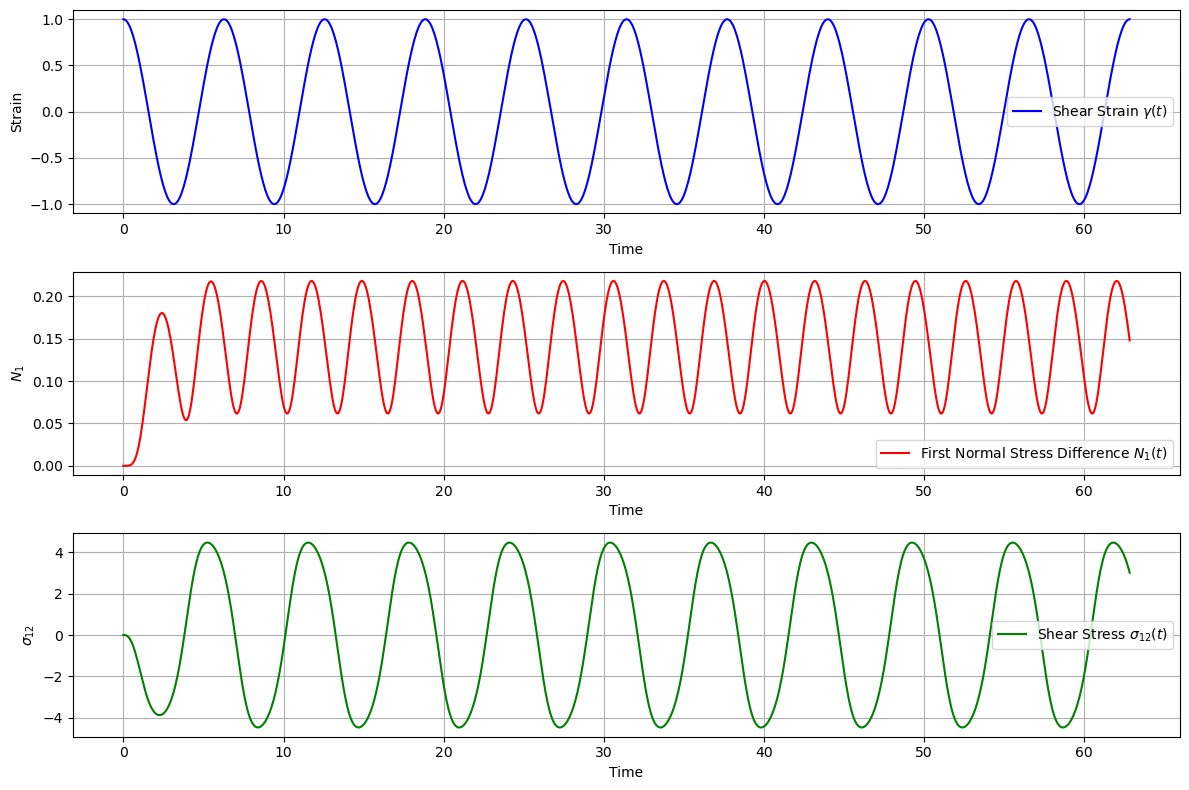

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# 材料参数
G0 = 1.0       # 弹性模量
tau = 1.0      # 松弛时间

# 时间参数
t_start = 0.0
T=2*np.pi
t_end = 10*T
num_points = 1000
time = np.linspace(t_start, t_end, num_points)
dt = time[1] - time[0]

# 剪切应变函数
gamma0 = 1.0   # 应变幅值
omega = 2*np.pi/T
gamma = gamma0 * np.cos(omega * time)

# 初始化应力分量
sigma11 = np.zeros_like(time)
sigma22 = np.zeros_like(time)
sigma12 = np.zeros_like(time)

# 数值积分计算应力
for i, t in enumerate(time):
    for j in range(i):
        t_prime = time[j]
        gamma_diff = gamma[i] - gamma[j]
        exp_term = np.exp(-(t - t_prime) / tau)
        
        # 取向张量函数 Q
        Q11 = (1 + gamma_diff**2) / (2 + gamma_diff**2)
        Q12 = gamma_diff / (2 + gamma_diff**2)
        Q22 = 1 / (2 + gamma_diff**2)
        
        # 应力积分
        sigma11[i] += G0 * exp_term * Q11 * dt
        sigma22[i] += G0 * exp_term * Q22 * dt
        sigma12[i] += G0 * exp_term * Q12 * dt*20

# 计算第一法向应力差
N1 = sigma11 - sigma22

# 绘制结果
plt.figure(figsize=(12, 8))

# 图 1: 剪切应变随时间的变化
plt.subplot(3, 1, 1)
plt.plot(time, gamma, label='Shear Strain $\gamma(t)$', color='b')
plt.xlabel('Time')
plt.ylabel('Strain')
plt.legend()
plt.grid()

# 图 2: 第一法向应力差 N1 随时间的变化
plt.subplot(3, 1, 2)
plt.plot(time, N1, label='First Normal Stress Difference $N_1(t)$', color='r')
plt.xlabel('Time')
plt.ylabel('$N_1$')
plt.legend()
plt.grid()

# 图 3: 剪切应力 σ12 随时间的变化
plt.subplot(3, 1, 3)
plt.plot(time, sigma12, label='Shear Stress $\sigma_{12}(t)$', color='g')
plt.xlabel('Time')
plt.ylabel('$\sigma_{12}$')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

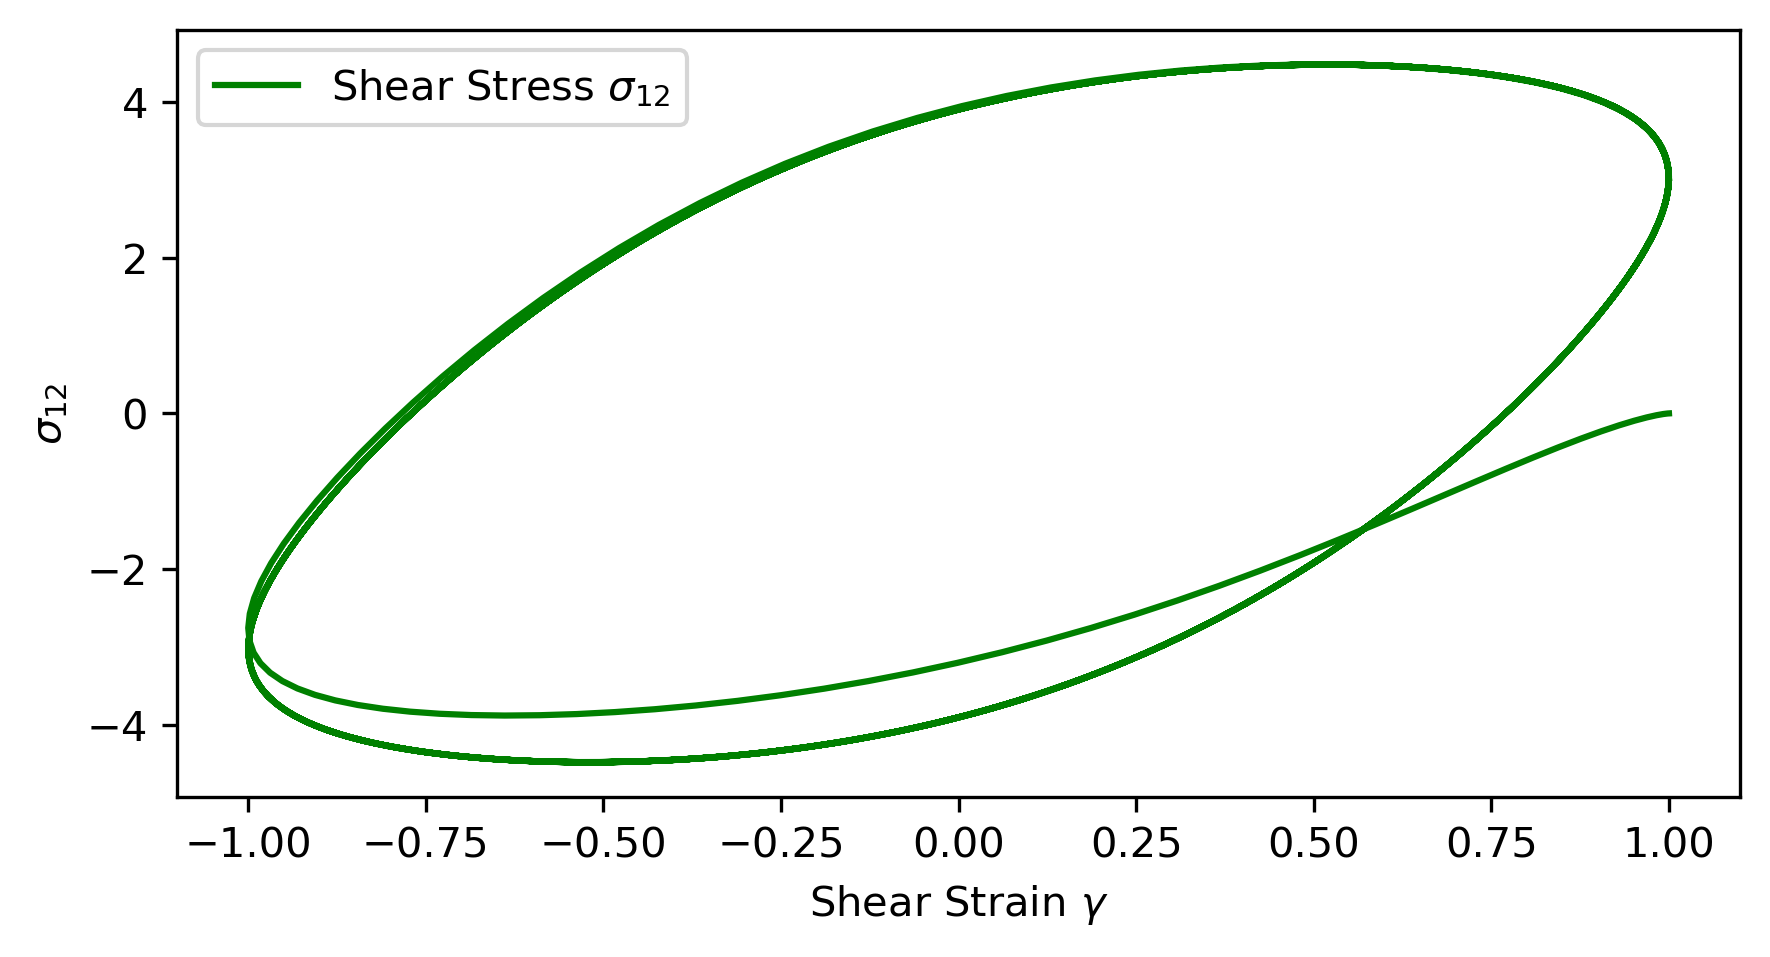

In [7]:
# 绘制 N1 和 σ12 随剪切应变 γ 的变化
plt.figure(figsize=(6, 6),dpi=300)

#plt.subplot(2, 1, 1)
#plt.plot(gamma, N1, label='First Normal Stress Difference $N_1$', color='r')
#plt.xlabel('Shear Strain $\gamma$')
#plt.ylabel('$N_1$')
#plt.legend()
#plt.grid()

plt.subplot(2, 1, 2)
plt.plot(gamma, sigma12, label='Shear Stress $\sigma_{12}$', color='g')
plt.xlabel('Shear Strain $\gamma$')
plt.ylabel('$\sigma_{12}$')
plt.legend()

plt.tight_layout()
plt.show()

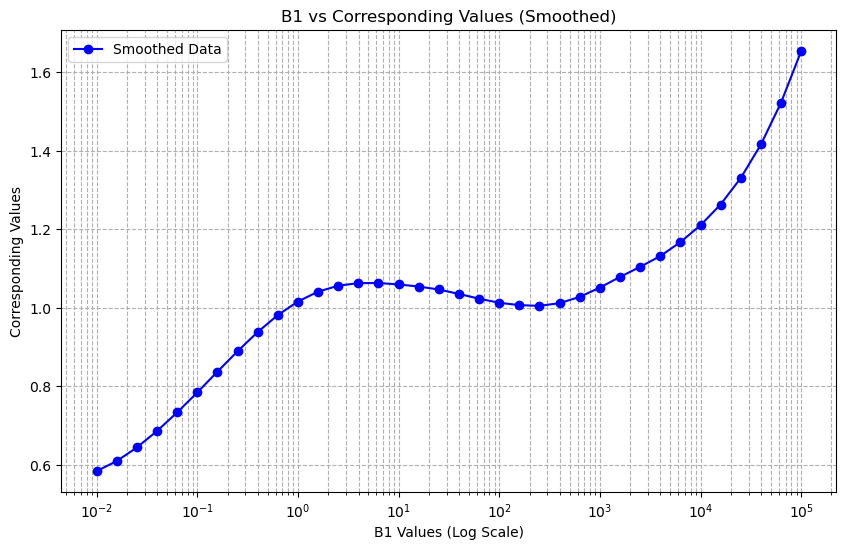

数据已导出到 smoothed_data.xlsx


In [49]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
import pandas as pd
# 数据
b1_values = [
    100000, 63100, 39800, 25100, 15800, 10000, 6310, 3980, 2510, 1580, 
    1000, 631, 398, 251, 158, 100, 63.1, 39.8, 25.1, 15.8, 
    10, 6.31, 3.98, 2.51, 1.58, 1, 0.631, 0.398, 0.251, 0.158, 
    0.1, 0.0631, 0.0398, 0.0251, 0.0158, 0.01
]

new_values = [
    1.65035, 1.5205, 1.4306, 1.3392, 1.2508, 1.19528, 1.17055, 1.144, 1.119,
    1.075, 1.053, 1.031, 1.01, 0.99, 1.00, 1.02, 1.03, 1.04007,
    1.04582, 1.0522, 1.05732, 1.05929, 1.0637, 1.05992, 1.04606, 1.02023, 0.98621,
    0.9377, 0.88793, 0.83564, 0.78398, 0.73421, 0.68696, 0.64412, 0.6101, 0.58364
]

# 对数据进行平滑处理
window_length = 11  # 窗口长度（必须是奇数）
polyorder = 3       # 多项式拟合的阶数
smoothed_values = savgol_filter(new_values, window_length, polyorder)
# 创建图表
plt.figure(figsize=(10, 6))

# 绘制原始数据
#plt.semilogx(b1_values, new_values, marker='s', linestyle='--', color='g', label='Original Data')

# 绘制平滑后的数据
plt.semilogx(b1_values, smoothed_values, marker='o', linestyle='-', color='b', label='Smoothed Data')

# 添加标题和标签
plt.title('B1 vs Corresponding Values (Smoothed)')
plt.xlabel('B1 Values (Log Scale)')
plt.ylabel('Corresponding Values')

# 添加网格
plt.grid(True, which="both", ls="--")

# 显示图例
plt.legend()

# 显示图表
plt.show()
# 将数据保存到 DataFrame
data = {
    'B1 Values': b1_values,
    'Original Values': new_values,
    'Smoothed Values': smoothed_values
}
df = pd.DataFrame(data)

# 导出到 Excel 文件
output_file = 'smoothed_data.xlsx'
df.to_excel(output_file, index=False)

print(f"数据已导出到 {output_file}")